In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
def timeseries_to_supervised(df, n_in, n_out):
   agg = pd.DataFrame()

   for i in range(n_in, 0, -1):
      df_shifted = df.shift(i).copy()
      df_shifted.rename(columns=lambda x: ('%s(t-%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)

   for i in range(0, n_out):
      df_shifted = df.shift(-i).copy()
      if i == 0:
         df_shifted.rename(columns=lambda x: ('%s(t)' % (x)), inplace=True)
      else:
         df_shifted.rename(columns=lambda x: ('%s(t+%d)' % (x, i)), inplace=True)
      agg = pd.concat([agg, df_shifted], axis=1)
   agg.dropna(inplace=True)
   return agg

In [3]:
data = pd.read_csv("../Data/data 2.csv", header = None, sep=',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   530 non-null    int64  
 1   1       530 non-null    float64
 2   2       530 non-null    float64
 3   3       530 non-null    float64
 4   4       530 non-null    float64
 5   5       530 non-null    float64
 6   6       530 non-null    float64
 7   7       530 non-null    float64
 8   8       530 non-null    float64
 9   9       530 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 41.5 KB




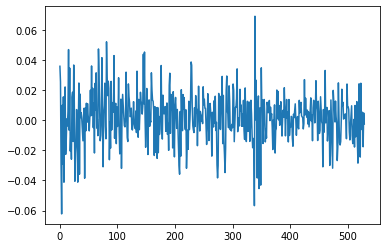

,index,1,2,3,4,5,6,7,8,9
0,0,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,1,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,3,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,4,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [4]:
# Data Cleaning

data = data[data.columns[1:]]
data.dropna(inplace=True)
data.reset_index(inplace=True)
data = data.iloc[:530]

data.info()
print("\n")
plt.plot(data[1])
plt.show()
print("\n")
data.head()

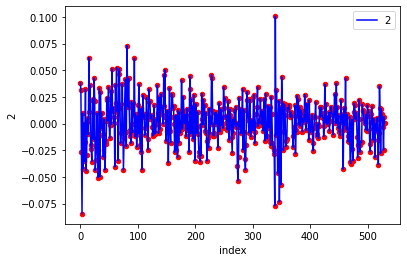

In [5]:
# a scatter plot comparing num_children and num_pets
ax = plt.gca()
data.plot(kind='line', x='index',y=2, color='blue', ax=ax)
data.plot(kind='scatter', x='index',y=2, color='red', ax=ax)
plt.show()

In [6]:
#Convert data to input-output
df = data[1].to_frame(name='ISE_TL')

df.head()

,ISE_TL
0,0.035754
1,0.025426
2,-0.028862
3,-0.062208
4,0.009860


In [7]:
# normalize the dataset
df0 = df.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.reshape(df['ISE_TL'].values, (df.shape[0], 1)))
df = pd.DataFrame(data=df, columns=['ISE_TL'])

df.head()

,ISE_TL
0,0.746889
1,0.668147
2,0.254242
3,0.000000
4,0.549467


In [8]:
n_in = 6
n_out = 1
sdf = timeseries_to_supervised(df, n_in, n_out)

sdf.head()

,ISE_TL(t-6),ISE_TL(t-5),ISE_TL(t-4),ISE_TL(t-3),ISE_TL(t-2),ISE_TL(t-1),ISE_TL(t)
6,0.746889,0.668147,0.254242,0.000000,0.549467,0.251732,0.592052
7,0.668147,0.254242,0.000000,0.549467,0.251732,0.592052,0.160419
8,0.254242,0.000000,0.549467,0.251732,0.592052,0.160419,0.479339
9,0.000000,0.549467,0.251732,0.592052,0.160419,0.479339,0.642311
10,0.549467,0.251732,0.592052,0.160419,0.479339,0.642311,0.301278


In [9]:
X, y = sdf[[('ISE_TL(t-%d)' % i) for i in range(6, 0, -1)]].values, sdf['ISE_TL(t)'].values
print(X.shape, y.shape)

(524, 6) (524,)


In [10]:
# Preparation for Training

# Split data into train and test
len_data = X.shape[0]
train_size = int(len_data * .5)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len_data - train_size))

xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:]
print(xtr.shape, ytr.shape)
print(xte.shape, yte.shape)

Train size: 262
Test size: 262
(262, 6) (262,)
(262, 6) (262,)


In [11]:
# Initialization of [samples, steps, features]

samples = train_size
steps = 1
features_in = n_in
features_out = n_out

In [12]:
xtr = np.reshape(xtr, (samples, steps, features_in))
ytr = np.reshape(ytr, (samples, steps, features_out))
print(xtr.shape, ytr.shape)
xte = np.reshape(xte, (samples, steps, features_in))
yte = np.reshape(yte, (samples, steps, features_out))
print(xte.shape, yte.shape)

(262, 1, 6) (262, 1, 1)
(262, 1, 6) (262, 1, 1)


In [13]:
#-------------------------------------------------- MLP & RNN -----------------------------------#
batch_size = 1 #1
model = Sequential()

# MLP
xtr, ytr = X[:train_size, :], y[:train_size]
xte, yte = X[train_size:, :], y[train_size:]

model.add(Dense(units=100, input_dim=xtr.shape[1], activation="relu"))
model.add(Dense(50, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# # RNN
# model.add(SimpleRNN(units=100, batch_input_shape=(batch_size, xtr.shape[1], 
#                                                 xtr.shape[2]), activation="relu", 
#                                                 return_sequences=True))
# model.add(Dense(50, activation="relu")) 
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.summary()


model.fit(xtr,ytr, epochs=10, batch_size=batch_size, verbose=0)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,801
Trainable params: 5,801
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Predicting and plotting the result
trainPredict = model.predict(xtr, batch_size=batch_size)
testPredict = model.predict(xte, batch_size=batch_size)

In [15]:
# invert predictions
trainPredict = np.reshape(trainPredict, (samples*steps, features_out))
ytr2d = np.reshape(ytr, (samples*steps, features_out))
testPredict = np.reshape(testPredict, (samples*steps, features_out))
yte2d = np.reshape(yte, (samples*steps, features_out))

In [16]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(ytr2d)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(yte2d)

In [17]:
# Calculate error
print("Test MSE: ", mean_squared_error(testY, testPredict))
print("Test MSE: ", sum(np.square(testY-testPredict))/testY.shape[0])
print("Test MAE: ", sum(abs(testY-testPredict))/testY.shape[0])
print("Test R2: ", r2_score(testY, testPredict))
print("Test R2: ", 1-(sum(np.square(testY-testPredict))/sum(np.square(testY-testY.mean()))))

Test MSE:  0.00022988309861643038
Test MSE:  [0.00022988]
Test MAE:  [0.01114386]
Test R2:  -0.05759813323646745
Test R2:  [-0.05759813]


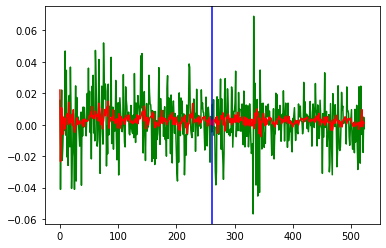

In [18]:
# Finally, we check the result in a plot. 
# A vertical line in a plot identifies a splitting point between 
# the training and the test part.
predicted = np.concatenate((trainPredict,testPredict),axis=0)

original = np.concatenate((trainY,testY),axis=0)
predicted = np.concatenate((trainPredict,testPredict),axis=0)
index = range(0, original.shape[0])
plt.plot(index,original, 'g')
plt.plot(index,predicted, 'r')
plt.axvline(df.index[train_size], c="b")
plt.show()